In [ ]:
from google.colab import drive
drive.mount('/content/drive')
sim_path = "/content/drive/MyDrive/CIS 5450/School Similarity/"

Mounted at /content/drive


In [ ]:
import pandas as pd, csv
import numpy as np
import json, requests
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from zipfile import ZipFile
from itertools import count
from scipy.spatial import distance_matrix
from cycler import cycler, Cycler
import seaborn as sns

In [ ]:
accent_cols = ['#F7EC09', '#3EC70B', '#3B44F6', '#A149FA']
accent_cols = accent_cols[::-1]
text_col = '#000000'
frame_col = '#000000'
grid_col = '#AAAAAA'
label_size = 14
tick_label_size = 12
title_size = 16
line_w = 4
fig_size = (10, 5)
custom_config = {
    'lines.linewidth': 2,
    'lines.linestyle': '--',
    'cycle_cols': accent_cols,
    'axes.labelcolor': text_col,
    'axes.titlecolor': text_col,
    'axes.labelsize': label_size,
    'axes.titlesize': title_size,
    'lines.linewidth': line_w,
    'figure.figsize': fig_size,
    'grid.color': grid_col,
    'xtick.color': frame_col,
    'xtick.labelsize': tick_label_size,
    'ytick.labelsize': tick_label_size,
    'ytick.color': frame_col,
    'axes.edgecolor': frame_col,
}

# Write config
path = "/content/drive/MyDrive/CIS 5450/mouse_config.json"
with open(path, 'w') as fp:
  json.dump(custom_config, fp)

In [ ]:
import json, requests, matplotlib as mpl
from cycler import cycler
sharing_link = "https://drive.google.com/file/d/1-9ohAAadugbNcn9nkzrqxZ8IOja5thxf/view?usp=sharing"
config_link = 'https://drive.google.com/uc?id=1-9ohAAadugbNcn9nkzrqxZ8IOja5thxf'
res = requests.get(config_link)
if res.ok:
  custom_config = json.loads(res.text)
else:
  err_str = f"Could not read config file from drive link! Received {res.status_code} : {res.reason}\n{res.text}"
  raise ConnectionError(err_str)

custom_config['axes.prop_cycle'] = cycler(color=custom_config['cycle_cols'])
custom_config
del(custom_config['cycle_cols'])
mpl.rcParams.update(**custom_config)
custom_config

{'lines.linewidth': 4,
 'lines.linestyle': '--',
 'axes.labelcolor': '#000000',
 'axes.titlecolor': '#000000',
 'axes.labelsize': 14,
 'axes.titlesize': 16,
 'figure.figsize': [10, 5],
 'grid.color': '#AAAAAA',
 'xtick.color': '#000000',
 'xtick.labelsize': 12,
 'ytick.labelsize': 12,
 'ytick.color': '#000000',
 'axes.edgecolor': '#000000',
 'axes.prop_cycle': cycler('color', ['#A149FA', '#3B44F6', '#3EC70B', '#F7EC09'])}

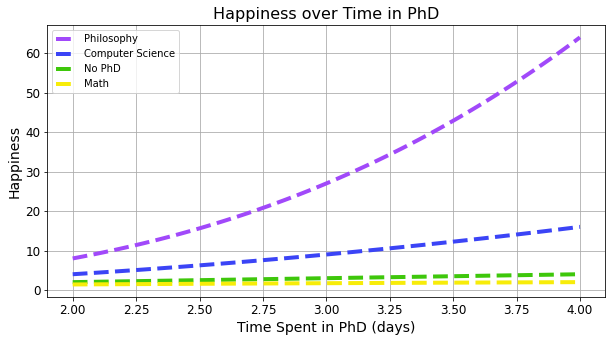

In [ ]:
xs = np.linspace(2, 4, 100)
mid = (np.max(xs) + np.min(xs)) / 2
ys = (xs - mid) ** 2
fig, ax = plt.subplots()

funcs = [lambda x: (x) ** 3, lambda x: (x) ** 2, lambda x: x, lambda x: x ** 0.5]
labels = ['Philosophy', 'Computer Science', 'No PhD', 'Math']

for i, func in enumerate(funcs):
  ys = func(xs)
  ax.plot(xs, ys, label=labels[i])

ax.legend()
ax.grid()
ax.set_xlabel("Time Spent in PhD (days)")
ax.set_ylabel("Happiness")
ax.set_title("Happiness over Time in PhD")
fig.savefig("/content/drive/MyDrive/CIS 5450/School Similarity/test.svg")
fig.show()

In [ ]:
posts_path = "/content/drive/MyDrive/CIS 5450/posts_stopped.csv"
df_posts = pd.read_csv(posts_path, parse_dates=["created"])
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57693 entries, 0 to 57692
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              57693 non-null  int64         
 1   subreddit_name  57693 non-null  object        
 2   summary         57655 non-null  object        
 3   text            43430 non-null  object        
 4   author_name     54721 non-null  object        
 5   comment_count   57693 non-null  int64         
 6   score           57693 non-null  int64         
 7   up_votes        57693 non-null  int64         
 8   down_votes      57693 non-null  int64         
 9   flair           12495 non-null  object        
 10  created         57693 non-null  datetime64[ns]
 11  awards          57693 non-null  object        
 12  url             57693 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 5.7+ MB


In [ ]:
comments_path = "/content/drive/MyDrive/CIS 5450/comments_stopped.csv"
df_comments = pd.read_csv(comments_path, parse_dates=["created"])
df_comments.describe()

,id,score,up_votes,down_votes,depth
count,505978.000000,505978.000000,505978.000000,505978.0,505978.000000
mean,34452.766907,7.967671,7.967671,0.0,1.194740
std,17491.725620,20.759897,20.759897,0.0,1.649368
min,1.000000,-459.000000,-459.000000,0.0,0.000000
25%,18892.000000,1.000000,1.000000,0.0,0.000000
50%,37668.000000,3.000000,3.000000,0.0,1.000000
75%,50466.000000,8.000000,8.000000,0.0,2.000000
max,57694.000000,2345.000000,2345.000000,0.0,9.000000


In [ ]:
# Drop duplicates and NA
df_posts = df_posts.drop_duplicates(["subreddit_name", "summary", "text", "author_name", "created"])
df_comments = df_comments[df_comments['id'].isin(df_posts.id)]

In [ ]:
# Concatenate to single DataFrame
df_sub = pd.concat([df_posts, df_comments], ignore_index=True, join='inner').sort_values("id")

# Filter out deleted and empty posts
df_sub = df_sub[df_sub["text"].str.strip() != "deleted"].dropna(subset=["text"])
df_sub

,id,subreddit_name,text,author_name,score,up_votes,down_votes,created,awards,url
0,1,upenn,nearly every woman know sexually assaulted ca...,Icy-Stomach-466,0,0,0,2021-12-05 01:36:58,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...
37068,1,upenn,thing looking silly,NaN,7,7,0,2021-12-05 04:26:48,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...
37066,1,upenn,good one,NaN,3,3,0,2021-12-05 21:15:10,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...
37065,1,upenn,perfect example much frat bros im assuming ob...,Icy-Stomach-466,-17,-17,0,2021-12-05 01:53:12,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...
37064,1,upenn,aau survey says 25 sa women 7 sa men however d...,NaN,3,3,0,2021-12-05 04:13:20,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...
...,...,...,...,...,...,...,...,...,...,...
408471,57694,gatech,triple option worked us prioritizes scheme ind...,Tagov,10,10,0,2022-09-06 14:36:45,[],/r/gatech/comments/x6zbbh/why_is_our_football_...
408472,57694,gatech,care post,OnceOnThisIsland,3,3,0,2022-09-06 15:05:42,[],/r/gatech/comments/x6zbbh/why_is_our_football_...
408473,57694,gatech,wrong caring football team performs tech pref...,NewAardvark6001,2,2,0,2022-09-06 14:15:52,[],/r/gatech/comments/x6zbbh/why_is_our_football_...
408475,57694,gatech,gt football absolutely makes huge profit comes...,TurboWreck,19,19,0,2022-09-06 11:43:02,[],/r/gatech/comments/x6zbbh/why_is_our_football_...


In [ ]:
cleaned_path = '/content/drive/MyDrive/CIS 5450/submissions_cleaned.csv'
df_sub.to_csv(cleaned_path, index=False)

In [ ]:
# Get all words
all_words = set((" ".join(df_sub.text)).split())

In [ ]:
zip_path = "/content/drive/MyDrive/CIS 5450/School Similarity/stanford_glove.zip"
fname = "glove.840B.300d.txt"
txt_path = "/".join(zip_path.split('.')[:-1]) + ".txt"
# with ZipFile(zip_path, "r") as zf:
#   with open(txt_path, "wb") as fp_out:
#     with zf.open(fname, "r") as fp_in:
#       for line in fp_in.readlines():
#         fp_out.write(line)

In [ ]:
# Read in vectors
vec_map = dict() # Prove that the decision problem of deciding if a graph $$G$$ has a directed Hamiltonian Path is NP complete
with open(txt_path, 'r') as fp:
  reader = csv.reader(fp, delimiter=' ', quotechar=None)
  for row in reader:
    word = row[0]
    if word in all_words:
      vec_map[word] = [float(val) for val in row[1:]]

In [ ]:
# Tokenize strings
df_out = df_sub.copy()
df_out["toks"] = df_sub["text"].astype(str).str.split()
df_out

,id,subreddit_name,text,author_name,score,up_votes,down_votes,created,awards,url,toks
0,1,upenn,nearly every woman know sexually assaulted ca...,Icy-Stomach-466,0,0,0,2021-12-05 01:36:58,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[nearly, every, woman, know, sexually, assault..."
37068,1,upenn,thing looking silly,NaN,7,7,0,2021-12-05 04:26:48,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[thing, looking, silly]"
37066,1,upenn,good one,NaN,3,3,0,2021-12-05 21:15:10,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[good, one]"
37065,1,upenn,perfect example much frat bros im assuming ob...,Icy-Stomach-466,-17,-17,0,2021-12-05 01:53:12,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[perfect, example, much, frat, bros, im, assum..."
37064,1,upenn,aau survey says 25 sa women 7 sa men however d...,NaN,3,3,0,2021-12-05 04:13:20,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[aau, survey, says, 25, sa, women, 7, sa, men,..."
...,...,...,...,...,...,...,...,...,...,...,...
408471,57694,gatech,triple option worked us prioritizes scheme ind...,Tagov,10,10,0,2022-09-06 14:36:45,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[triple, option, worked, us, prioritizes, sche..."
408472,57694,gatech,care post,OnceOnThisIsland,3,3,0,2022-09-06 15:05:42,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[care, post]"
408473,57694,gatech,wrong caring football team performs tech pref...,NewAardvark6001,2,2,0,2022-09-06 14:15:52,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[wrong, caring, football, team, performs, tech..."
408475,57694,gatech,gt football absolutely makes huge profit comes...,TurboWreck,19,19,0,2022-09-06 11:43:02,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[gt, football, absolutely, makes, huge, profit..."


In [ ]:
def get_avg_vec(toks: "list[str]"):
  vecs = np.array([vec_map[word] for word in toks if word in vec_map.keys()])
  if len(vecs.shape) != 2 or vecs.shape[0] < 1:
    return np.NAN
  return np.mean(vecs, axis=0)

df_out["vec"] = df_out.toks.apply(get_avg_vec)
df_out

,id,subreddit_name,text,author_name,score,up_votes,down_votes,created,awards,url,toks,vec
0,1,upenn,nearly every woman know sexually assaulted ca...,Icy-Stomach-466,0,0,0,2021-12-05 01:36:58,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[nearly, every, woman, know, sexually, assault...","[-0.15202529522727273, 0.10482591666666663, -0..."
37068,1,upenn,thing looking silly,NaN,7,7,0,2021-12-05 04:26:48,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[thing, looking, silly]","[-0.20675666666666667, -0.10843933333333333, -..."
37066,1,upenn,good one,NaN,3,3,0,2021-12-05 21:15:10,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[good, one]","[-0.18608950000000002, 0.2771, -0.245369999999..."
37065,1,upenn,perfect example much frat bros im assuming ob...,Icy-Stomach-466,-17,-17,0,2021-12-05 01:53:12,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[perfect, example, much, frat, bros, im, assum...","[-0.110018125, 0.10523690625000001, -0.1210980..."
37064,1,upenn,aau survey says 25 sa women 7 sa men however d...,NaN,3,3,0,2021-12-05 04:13:20,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[aau, survey, says, 25, sa, women, 7, sa, men,...","[-0.2121839689189189, 0.16659396756756759, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
408471,57694,gatech,triple option worked us prioritizes scheme ind...,Tagov,10,10,0,2022-09-06 14:36:45,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[triple, option, worked, us, prioritizes, sche...","[-0.1084586769230769, 0.16113343846153846, -0...."
408472,57694,gatech,care post,OnceOnThisIsland,3,3,0,2022-09-06 15:05:42,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[care, post]","[-0.25383, 0.281069, -0.144703, 0.037910000000..."
408473,57694,gatech,wrong caring football team performs tech pref...,NewAardvark6001,2,2,0,2022-09-06 14:15:52,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[wrong, caring, football, team, performs, tech...","[-0.16552546818181815, 0.15075159090909088, -0..."
408475,57694,gatech,gt football absolutely makes huge profit comes...,TurboWreck,19,19,0,2022-09-06 11:43:02,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[gt, football, absolutely, makes, huge, profit...","[-0.03635994827586208, 0.18911893103448277, 0...."


In [ ]:
# Filter out posts that could not be vectorized
df_out = df_out.dropna(subset=["vec"])
df_out

,id,subreddit_name,text,author_name,score,up_votes,down_votes,created,awards,url,toks,vec
0,1,upenn,nearly every woman know sexually assaulted ca...,Icy-Stomach-466,0,0,0,2021-12-05 01:36:58,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[nearly, every, woman, know, sexually, assault...","[-0.15202529522727273, 0.10482591666666663, -0..."
37068,1,upenn,thing looking silly,NaN,7,7,0,2021-12-05 04:26:48,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[thing, looking, silly]","[-0.20675666666666667, -0.10843933333333333, -..."
37066,1,upenn,good one,NaN,3,3,0,2021-12-05 21:15:10,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[good, one]","[-0.18608950000000002, 0.2771, -0.245369999999..."
37065,1,upenn,perfect example much frat bros im assuming ob...,Icy-Stomach-466,-17,-17,0,2021-12-05 01:53:12,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[perfect, example, much, frat, bros, im, assum...","[-0.110018125, 0.10523690625000001, -0.1210980..."
37064,1,upenn,aau survey says 25 sa women 7 sa men however d...,NaN,3,3,0,2021-12-05 04:13:20,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[aau, survey, says, 25, sa, women, 7, sa, men,...","[-0.2121839689189189, 0.16659396756756759, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
408471,57694,gatech,triple option worked us prioritizes scheme ind...,Tagov,10,10,0,2022-09-06 14:36:45,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[triple, option, worked, us, prioritizes, sche...","[-0.1084586769230769, 0.16113343846153846, -0...."
408472,57694,gatech,care post,OnceOnThisIsland,3,3,0,2022-09-06 15:05:42,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[care, post]","[-0.25383, 0.281069, -0.144703, 0.037910000000..."
408473,57694,gatech,wrong caring football team performs tech pref...,NewAardvark6001,2,2,0,2022-09-06 14:15:52,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[wrong, caring, football, team, performs, tech...","[-0.16552546818181815, 0.15075159090909088, -0..."
408475,57694,gatech,gt football absolutely makes huge profit comes...,TurboWreck,19,19,0,2022-09-06 11:43:02,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[gt, football, absolutely, makes, huge, profit...","[-0.03635994827586208, 0.18911893103448277, 0...."


In [ ]:
# Create weights column
df_out.loc[:,"trans_score"] = np.abs(df_out.score) + 1
for school in list(df_out.subreddit_name.unique()):
  total_score = df_out[df_out["subreddit_name"] == school].trans_score.sum()
  df_out.loc[df_out["subreddit_name"] == school, "weight"] = df_out[df_out["subreddit_name"] == school].trans_score / total_score
df_out.loc[:,"weighted_vec"] = df_out.vec * df_out.weight
df_out

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,id,subreddit_name,text,author_name,score,up_votes,down_votes,created,awards,url,toks,vec,trans_score,weight,weighted_vec
0,1,upenn,nearly every woman know sexually assaulted ca...,Icy-Stomach-466,0,0,0,2021-12-05 01:36:58,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[nearly, every, woman, know, sexually, assault...","[-0.15202529522727273, 0.10482591666666663, -0...",1,0.000004,"[-5.703657808481756e-07, 3.9328399739876424e-0..."
37068,1,upenn,thing looking silly,NaN,7,7,0,2021-12-05 04:26:48,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[thing, looking, silly]","[-0.20675666666666667, -0.10843933333333333, -...",8,0.000030,"[-6.205647682649259e-06, -3.2547259948475526e-..."
37066,1,upenn,good one,NaN,3,3,0,2021-12-05 21:15:10,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[good, one]","[-0.18608950000000002, 0.2771, -0.245369999999...",4,0.000015,"[-2.792669017783447e-06, 4.158475275755984e-06..."
37065,1,upenn,perfect example much frat bros im assuming ob...,Icy-Stomach-466,-17,-17,0,2021-12-05 01:53:12,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[perfect, example, much, frat, bros, im, assum...","[-0.110018125, 0.10523690625000001, -0.1210980...",18,0.000068,"[-7.429752569970736e-06, 7.1068669336684935e-0..."
37064,1,upenn,aau survey says 25 sa women 7 sa men however d...,NaN,3,3,0,2021-12-05 04:13:20,[],/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,"[aau, survey, says, 25, sa, women, 7, sa, men,...","[-0.2121839689189189, 0.16659396756756759, -0....",4,0.000015,"[-3.1842720630137153e-06, 2.500097059616832e-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408471,57694,gatech,triple option worked us prioritizes scheme ind...,Tagov,10,10,0,2022-09-06 14:36:45,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[triple, option, worked, us, prioritizes, sche...","[-0.1084586769230769, 0.16113343846153846, -0....",11,0.000012,"[-1.2837487113546056e-06, 1.9072226386077539e-..."
408472,57694,gatech,care post,OnceOnThisIsland,3,3,0,2022-09-06 15:05:42,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[care, post]","[-0.25383, 0.281069, -0.144703, 0.037910000000...",4,0.000004,"[-1.0925113924323044e-06, 1.209750953628631e-0..."
408473,57694,gatech,wrong caring football team performs tech pref...,NewAardvark6001,2,2,0,2022-09-06 14:15:52,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[wrong, caring, football, team, performs, tech...","[-0.16552546818181815, 0.15075159090909088, -0...",3,0.000003,"[-5.34329451974729e-07, 4.866381943490014e-07,..."
408475,57694,gatech,gt football absolutely makes huge profit comes...,TurboWreck,19,19,0,2022-09-06 11:43:02,[],/r/gatech/comments/x6zbbh/why_is_our_football_...,"[gt, football, absolutely, makes, huge, profit...","[-0.03635994827586208, 0.18911893103448277, 0....",20,0.000022,"[-7.824854768866692e-07, 4.0699402489814385e-0..."


In [ ]:
# Get average vector of each university by averaging across posts
df_final = (df_out[["subreddit_name", "weighted_vec"]].groupby('subreddit_name', as_index=False).sum())
df_final

,subreddit_name,weighted_vec
0,berkeley,"[-0.08972319794029214, 0.08379847081887748, -0..."
1,brownu,"[-0.06341702467552757, 0.11099413663073426, -0..."
2,caltech,"[-0.05091759396017272, 0.11834873652734361, -0..."
3,cmu,"[-0.07023040701868409, 0.11208484294764465, -0..."
4,columbia,"[-0.07558301305863854, 0.09548110846871125, -0..."
5,cornell,"[-0.1228960840727964, 0.08269067367875706, -0...."
6,dartmouth,"[-0.04884254524923134, 0.11822209239057872, -0..."
7,gatech,"[-0.08501825248784046, 0.10011491266722307, -0..."
8,harvard,"[-0.06817504660272436, 0.10565675854019087, -0..."
9,mit,"[-0.06618467199653613, 0.11125621238769026, -0..."


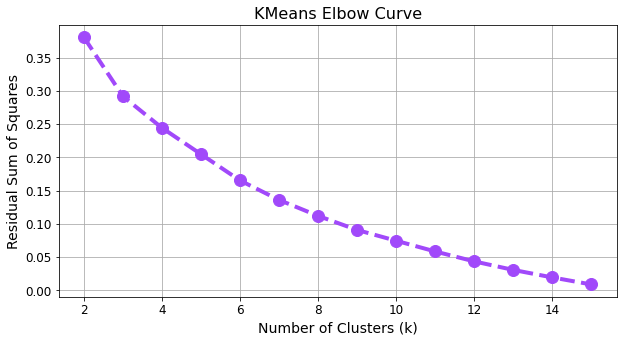

In [ ]:
k_vals = list(range(2, len(df_final.index)))
errs = list()
vecs = np.array(df_final.weighted_vec.to_list())
for k in k_vals:
  kmeans = KMeans(k)
  df_final.loc[:,f"cluster_{k}"] = kmeans.fit_predict(vecs)
  errs.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Residual Sum of Squares')
ax.set_title('KMeans Elbow Curve')
ax.plot(k_vals, errs, marker='o', markersize=12)
ax.grid()
fig.savefig(sim_path + 'kmeans_curve.svg')
fig.show()

In [ ]:
df_final[["subreddit_name", "cluster_6"]].sort_values("cluster_6")

,subreddit_name,cluster_6
3,cmu,0
8,harvard,0
9,mit,0
11,stanford,0
15,yale,0
2,caltech,1
0,berkeley,2
7,gatech,2
13,uiuc,2
4,columbia,3


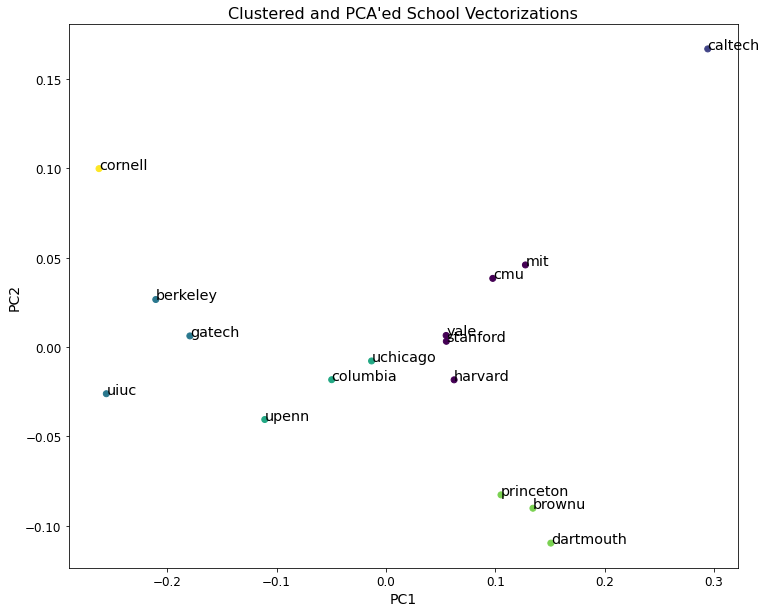

In [ ]:
pca = PCA(2)
pca_vecs = np.array(df_final.weighted_vec.to_list())
post_pca_vecs = pca.fit_transform(pca_vecs)

fig, ax = plt.subplots()
ax.scatter(post_pca_vecs[:, 0], post_pca_vecs[:, 1], c=df_final["cluster_6"], )
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Clustered and PCA'ed School Vectorizations")

for i, txt in enumerate(df_final.subreddit_name):
    ax.annotate(txt, (post_pca_vecs[i, 0], post_pca_vecs[i, 1]), fontsize="x-large")
fig.savefig("/content/drive/MyDrive/CIS 5450/School Similarity/vectorization.png")
fig.set_size_inches((12, 10))
fig.show()

In [ ]:
# Compute pairwise distances
schools = list(df_final.subreddit_name.unique())
vecs = np.array(df_final.weighted_vec.to_list())
dist = np.zeros((len(schools), len(schools)))
for i, school1 in enumerate(schools):
  for j, school2 in enumerate(schools):
    print(vecs[i, :])
    dist[i, j] = np.linalg.norm(vecs[i, :] - vecs[j,:], axis=0)

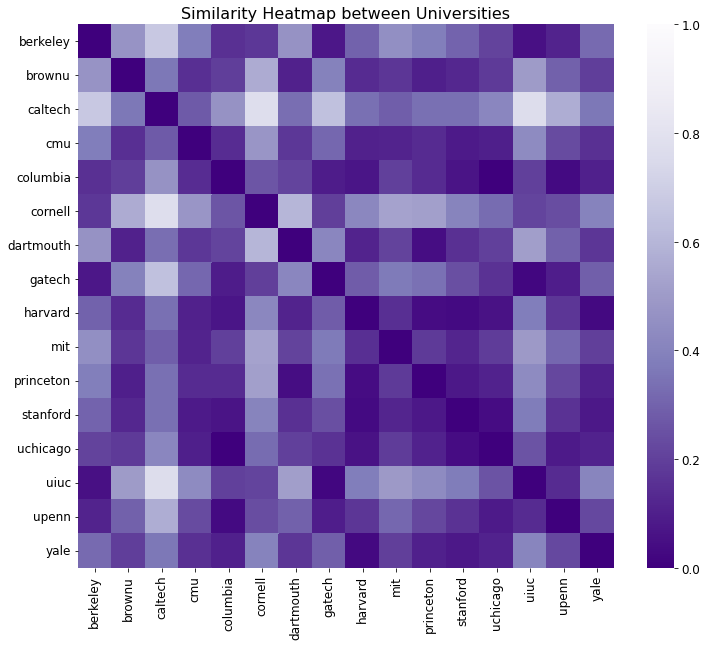

In [ ]:
dist = distance_matrix(vecs, vecs)
vals = [val for val in dist.flatten() if val > 0]

total_min, total_max = min(vals), max(vals)
total_mean = np.mean(vals)

dist = (dist - total_min) / total_max
fig, ax = plt.subplots()
sns.heatmap(dist, ax=ax, xticklabels=schools, yticklabels=schools, cmap="Purples_r", vmin=0, vmax=1)
ax.set_title('Similarity Heatmap between Universities')
fig.set_size_inches(12, 10)
fig.savefig(sim_path + 'sim_heatmap.svg')
fig.show()

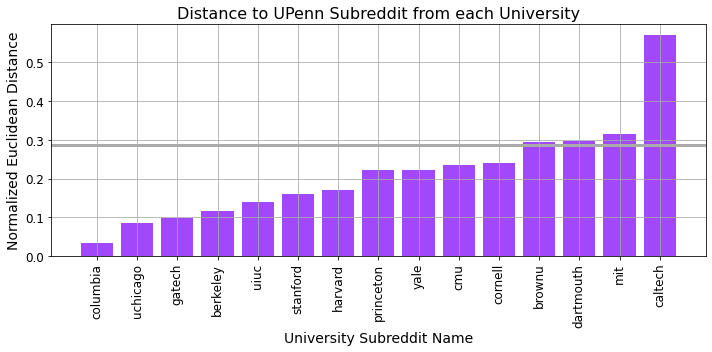

In [ ]:
# fig, ax = plt.subplots()
penn_i = None
for i, school in enumerate(schools):
  if school == 'upenn':
    penn_i = i
    break
if penn_i is None:
  raise ValueError(f"Did not find upenn in schools list!")

sims = pd.Series(dist[penn_i,:], schools)
sims = sims.sort_values().drop(['upenn'])

fig, ax = plt.subplots()
ax.bar(sims.index, sims)
ax.set_xlabel('University Subreddit Name')
ax.set_ylabel('Normalized Euclidean Distance')
ax.set_title('Distance to UPenn Subreddit from each University')
ax.set_xticklabels(sims.index, rotation = 90)
ax.axhline(total_mean, color='#AAAAAA', linewidth=3, linestyle='-')
ax.grid()
fig.tight_layout()
fig.savefig(sim_path + 'upenn_dist.svg')

fig.show()


In [ ]:
# Create pairwise matrix
recs = list()

for i, school1 in enumerate(schools):
  for j, school2 in enumerate(schools):
    rec = list()
    rec.append(school1)
    rec.append(school2)
    rec.append(dist[i, j])
    recs.append(rec)

df_pair = pd.DataFrame(recs, columns=["school_1", "school_2", "vec_dist"])
df_pair

,school_1,school_2,vec_dist
0,berkeley,berkeley,0.000000
1,berkeley,brownu,0.413493
2,berkeley,caltech,0.536243
3,berkeley,cmu,0.361130
4,berkeley,columbia,0.225902
...,...,...,...
251,yale,stanford,0.181285
252,yale,uchicago,0.198543
253,yale,uiuc,0.377628
254,yale,upenn,0.266374


In [ ]:
# Compute geographic distance
dist_path = "/content/drive/MyDrive/CIS 5450/School Similarity/uni_locations.csv"
df_geo = pd.read_csv(dist_path).set_index("subreddit_name")
longs = df_geo.longitude
lats = df_geo.latitude

def get_geo_dist(longs, lats, school1, school2):
  """Returns distance in mi of two schools"""
  long1, lat1 = longs[school1], lats[school1]
  long2, lat2 = longs[school2], lats[school2]

  arr = np.array([[long1, lat1], [long2, lat2]])
  arr /= (180 / np.pi)

  long1, lat1 = arr[0]
  long2, lat2 = arr[1]

  d = 3963.0 * np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(long2 - long1))

  return d

df_pair["geo_dist"] = df_pair.apply(lambda x: get_geo_dist(longs, lats, x["school_1"], x["school_2"]), axis=1)
df_pair

,school_1,school_2,vec_dist,geo_dist
0,berkeley,berkeley,0.000000,0.000000
1,berkeley,brownu,0.413493,3515.517824
2,berkeley,caltech,0.536243,313.883418
3,berkeley,cmu,0.361130,2926.313103
4,berkeley,columbia,0.225902,3339.480009
...,...,...,...,...
251,yale,stanford,0.181285,3404.429184
252,yale,uchicago,0.198543,1015.128432
253,yale,uiuc,0.377628,1058.636231
254,yale,upenn,0.266374,159.197517


In [ ]:
df_pair.school_1.unique()

array(['berkeley', 'brownu', 'caltech', 'cmu', 'columbia', 'cornell',
       'dartmouth', 'gatech', 'harvard', 'mit', 'princeton', 'stanford',
       'uchicago', 'uiuc', 'upenn', 'yale'], dtype=object)

In [ ]:
data_path = '/content/drive/MyDrive/CIS 5450/School Similarity/college_data.csv'


# df_pair["pop_dist"] = df_pair.apply(lambda x: abs(pop[x.school_1] - pop[x.school_2]), axis=1)
# df_pair
df_data = pd.read_csv(data_path).drop(["Address", "Website", "Awards offered", "Campus housing", "Graduation Rate", "Transfer-Out Rate", "Cohort Year *", "Net Price **"], axis=1)
name_map = {
    "University of Pennsylvania": "upenn",
    "Brown University": "brownu",
    "Columbia University in the City of New York":"columbia",
    "Harvard University": "harvard",
    "Dartmouth College": "dartmouth",
    "University of California-Berkeley": "berkeley",
    "Georgia Institute of Technology-Main Campus": "gatech",
    "University of Illinois Urbana-Champaign": "uiuc",
    "Carnegie Mellon University": "cmu",
    "Cornell University": "cornell",
    "California Institute of Technology": "caltech",
    "Stanford University": "stanford",
    "University of Chicago": "uchicago",
    "Massachusetts Institute of Technology": "mit",
    "Yale University": "yale",
    "Princeton University": "princeton"
}
df_data["subreddit_name"] = df_data.Name.map(name_map)
df_data.loc[df_data.Type.str.contains("Private"),"type"] = 1
df_data.loc[df_data.Type.str.contains("Public"),"type"] = 0
setting_map = {
    "City: Large": 7,
    "City: Midsize": 6,
    "City: Small": 5,
    "Suburb: Large": 4,
    "Suburb: Midsize": 3,
    "Suburb: Small": 2,
    "Town: Remote": 1
}
df_data["setting"] = df_data["Campus setting"].map(setting_map)
df_data = df_data.rename({
    "Student population": "pop",
    "Undergraduate students": "undergrad_pop"
}, axis=1).set_index("subreddit_name")
df_data["in_city"] = df_data["Campus setting"].str.contains("City").astype(int)
df_data

,Name,Type,Campus setting,pop,undergrad_pop,type,setting,in_city
subreddit_name,,,,,,,,
upenn,University of Pennsylvania,"4-year, Private not-for-profit",City: Large,28038,11292,1.0,7,1
brownu,Brown University,"4-year, Private not-for-profit",City: Midsize,10696,7349,1.0,6,1
princeton,Princeton University,"4-year, Private not-for-profit",City: Small,8478,5321,1.0,5,1
columbia,Columbia University in the City of New York,"4-year, Private not-for-profit",City: Large,33776,8832,1.0,7,1
harvard,Harvard University,"4-year, Private not-for-profit",City: Midsize,31345,9579,1.0,6,1
dartmouth,Dartmouth College,"4-year, Private not-for-profit",Town: Remote,6761,4556,1.0,1,0
berkeley,University of California-Berkeley,"4-year, Public",City: Midsize,45036,31814,0.0,6,1
gatech,Georgia Institute of Technology-Main Campus,"4-year, Public",City: Large,43859,17461,0.0,7,1
uiuc,University of Illinois Urbana-Champaign,"4-year, Public",City: Small,56607,34779,0.0,5,1


In [ ]:
# Combine data dataframe
df_merged = pd.merge(pd.merge(df_data.reset_index(), df_final.drop([f"cluster_{i}" for i in range(2, 16)], axis=1), how="inner", on="subreddit_name"), df_geo, on="subreddit_name").set_index("subreddit_name")
df_merged

,Name,Type,Campus setting,pop,undergrad_pop,type,setting,in_city,weighted_vec,longitude,latitude
subreddit_name,,,,,,,,,,,
upenn,University of Pennsylvania,"4-year, Private not-for-profit",City: Large,28038,11292,1.0,7,1,"[-0.08490068098400089, 0.1038941692288731, -0....",39.952054,-75.193514
brownu,Brown University,"4-year, Private not-for-profit",City: Midsize,10696,7349,1.0,6,1,"[-0.06341702467552757, 0.11099413663073426, -0...",41.826724,-71.402441
princeton,Princeton University,"4-year, Private not-for-profit",City: Small,8478,5321,1.0,5,1,"[-0.05451744562944061, 0.1122650619452642, -0....",40.343082,-74.655052
columbia,Columbia University in the City of New York,"4-year, Private not-for-profit",City: Large,33776,8832,1.0,7,1,"[-0.07558301305863854, 0.09548110846871125, -0...",40.807568,-73.962637
harvard,Harvard University,"4-year, Private not-for-profit",City: Midsize,31345,9579,1.0,6,1,"[-0.06817504660272436, 0.10565675854019087, -0...",42.376860,-71.116649
dartmouth,Dartmouth College,"4-year, Private not-for-profit",Town: Remote,6761,4556,1.0,1,0,"[-0.04884254524923134, 0.11822209239057872, -0...",43.704642,-72.288189
berkeley,University of California-Berkeley,"4-year, Public",City: Midsize,45036,31814,0.0,6,1,"[-0.08972319794029214, 0.08379847081887748, -0...",37.872119,-122.258615
gatech,Georgia Institute of Technology-Main Campus,"4-year, Public",City: Large,43859,17461,0.0,7,1,"[-0.08501825248784046, 0.10011491266722307, -0...",33.774856,-84.397220
uiuc,University of Illinois Urbana-Champaign,"4-year, Public",City: Small,56607,34779,0.0,5,1,"[-0.09304650801159285, 0.09693967197735624, -0...",40.101944,-88.227419


In [ ]:
df_geo

,longitude,latitude
subreddit_name,,
brownu,41.826724,-71.402441
dartmouth,43.704642,-72.288189
princeton,40.343082,-74.655052
berkeley,37.872119,-122.258615
gatech,33.774856,-84.397220
uiuc,40.101944,-88.227419
cmu,40.443113,-79.942936
mit,42.359885,-71.094321
cornell,42.453592,-76.473749


In [ ]:
for diff_var in ["pop", "undergrad_pop", "type", "setting", "longitude", "latitude", "in_city"]:
  df_pair[f"{diff_var}_diff"] = df_pair.apply(lambda x: abs(df_merged[diff_var][x.school_1] - df_merged[diff_var][x.school_2]), axis=1)

df_pair

,school_1,school_2,vec_dist,geo_dist,pop_diff,undergrad_pop_diff,type_diff,setting_diff,longitude_diff,latitude_diff,in_city_diff
0,berkeley,berkeley,0.000000,0.000000,0,0,0.0,0,0.000000,0.000000,0
1,berkeley,brownu,0.413493,3515.517824,34340,24465,1.0,0,3.954604,50.856174,0
2,berkeley,caltech,0.536243,313.883418,42639,30827,1.0,0,3.734266,4.133153,0
3,berkeley,cmu,0.361130,2926.313103,29979,24882,1.0,1,2.570993,42.315679,0
4,berkeley,columbia,0.225902,3339.480009,11260,22982,1.0,1,2.935449,48.295978,0
...,...,...,...,...,...,...,...,...,...,...,...
251,yale,stanford,0.181285,3404.429184,3113,1109,0.0,2,3.888758,49.247376,1
252,yale,uchicago,0.198543,1015.128432,4265,1100,0.0,1,0.472404,14.676306,0
253,yale,uiuc,0.377628,1058.636231,42040,28243,1.0,1,1.214348,15.304979,0
254,yale,upenn,0.266374,159.197517,13471,4756,0.0,1,1.364238,2.271074,0


In [ ]:
df_corr = df_pair[df_pair["school_1"] != df_pair["school_2"]].corr().sort_values('vec_dist', ascending=False)
df_corr

,vec_dist,geo_dist,pop_diff,undergrad_pop_diff,type_diff,setting_diff,longitude_diff,latitude_diff,in_city_diff
vec_dist,1.000000,0.148211,0.599091,0.585003,0.359883,-0.045607,0.231754,0.147968,-0.101512
pop_diff,0.599091,0.083364,1.000000,0.792194,0.722518,-0.031286,0.145103,0.082940,-0.085195
undergrad_pop_diff,0.585003,0.232271,0.792194,1.000000,0.809687,-0.109863,0.078025,0.231805,-0.136046
type_diff,0.359883,0.170518,0.722518,0.809687,1.000000,-0.120318,0.257582,0.169739,-0.130405
longitude_diff,0.231754,0.466246,0.145103,0.078025,0.257582,0.069170,1.000000,0.465658,0.105225
geo_dist,0.148211,1.000000,0.083364,0.232271,0.170518,-0.057563,0.466246,0.999994,0.192029
latitude_diff,0.147968,0.999994,0.082940,0.231805,0.169739,-0.058548,0.465658,1.000000,0.190669
setting_diff,-0.045607,-0.057563,-0.031286,-0.109863,-0.120318,1.000000,0.069170,-0.058548,0.754280
in_city_diff,-0.101512,0.192029,-0.085195,-0.136046,-0.130405,0.754280,0.105225,0.190669,1.000000


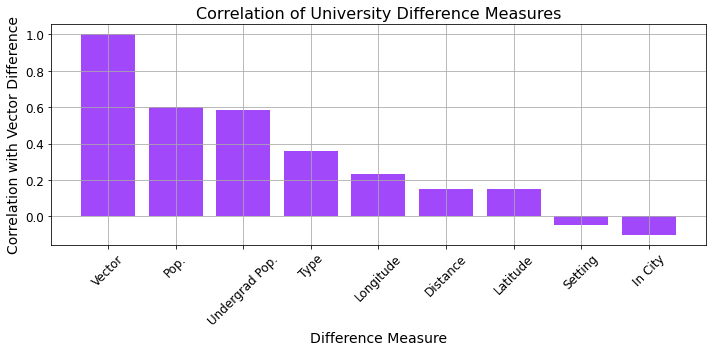

In [ ]:
fig, ax = plt.subplots()
label_map = {
    'vec_dist': 'Vector',
    'pop_diff': 'Pop.',
    'undergrad_pop_diff': 'Undergrad Pop.',
    'type_diff': 'Type',
    'longitude_diff': 'Longitude',
    'geo_dist': 'Distance',
    'latitude_diff': 'Latitude',
    'setting_diff': 'Setting',
    'in_city_diff': 'In City'
}

labels = [label_map[label] for label in df_corr.vec_dist.index]
ax.bar(labels, df_corr.vec_dist)
ax.grid()
ax.set_xlabel('Difference Measure')
ax.set_ylabel('Correlation with Vector Difference')
ax.set_title('Correlation of University Difference Measures')
ax.set_xticklabels(labels, rotation=45)
fig.tight_layout()
fig.savefig(sim_path + 'corr_barchart.svg')
fig.show()